# Group Final Report

### Christin Wang, Rongze Wang

## I. Introduction


## 1. Data Discription ##
In this project, we will use the dataset `processed.cleveland.data`, which contains data on the heart quality variables of 302 patients and their identity variables undergoing angiography at the Cleveland Clinic in Cleveland, Ohio. The database selects 14 varaibles from 76 attributions. The data comes from the UCI Machine Learning repository https://doi.org/10.24432/C52P4X.

The definition of each selected variable:
- `age`: a numerical variable that measures the age of patients in years.
- `sex`: a categorical variable where 1 = male and 0 = female.
- `cp`: a categorical variable that indicates the chest pain type: 
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic.
- `trestps`: a numerical variable that measures the resting blood pressure (in mm Hg on admission to the hospital).
- `chol`: a numerical variable that measures the serum cholestoral in mg/dl.
- `fbs`: a categorical variable that indicates the fasting blood sugar (> 120 mg/dl) where 1 = true and 0 = false.
- `restecg`: a categorical variable that indicates the resting electrocardiographic results:  
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria.
- `thalach`: a numerical variable that measures the maximum heart rate achieved.
- `exang`: a categorical variable that indicates the exercise induced angina (1 = yes; 0 = no).
- `oldpeak`: a numerical variable that measures the ST depression induced by exercise relative to rest.
- `slope`: a categorical variable that indicates the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping.
- `ca`: a numerical variable that indicates the number of major vessels (0-3) colored by flourosopy.
- `thal`: a categorical variable where 3 = normal; 6 = fixed defect; 7 = reversable defect.
- `num`: a numerical variable that indicates the diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels).

## 2. Question & Literature Reviews

As Coronary Artery Disease (CAD) is identified as one of the most leading reasons of mortality, scientists have been widely studied on the possible causes of CAD (Jones, L., et al., 1999, Inouye, M., et al., 2018).

The lifetime risk of CAD is significantly high, with men being more at risk than women, and the risk remains substantial among older individuals. Additionally, high blood pressure and hypercholesterolemia, characterized by elevated cholesterol levels, are major contributors to the risk of CAD (Lloyd-Jones, Larson, Beiser, & Levy, 1999).

Meanwhile, Inouye et al. (2018) highlighted that the occurrence of CAD can be associated with genetic characteristics. Although diabetes, which leads to high blood sugar, can be inherited, it has rarely been included in previous research. While extensive studies have focused on factors like age, sex, blood pressure, and cholesterol level, the role of blood sugar remains unclear.

This leads to our question: “Are sex, age, blood pressure, cholesterol level and blood sugar associated with heart disease diagnosis in the Cleveland dataset?”

To address this, we will use the Cleveland heart disease dataset (Janosi et al., 1988) to estimate the association between heart disease diagnosis and these factors. The dataset includes 13 variables and 1 response variable, collected from medical records for heart disease research. Its primary use is to distinguish between the presence (values 1, 2, 3, 4) and absence (value 0) of heart disease.


## II. Methods and Results

### A. Exploratory Data Analysis

In [3]:
library(MASS)
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(modelr)
library(gridExtra)
library(grid)
library(rsample)
library(yardstick)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(caret)
library(ISLR)
library(pROC)

### 1. Data Preparation

- Read the csv file of `processed.cleveland.data`.
- Rename the column names of the dataset.
- Change the diagnosis presence values (1,2,3,4) all into 1.
- Mutate all catagorical variables into factors for coding convinience.
- Drop any NA values.

In [4]:
# Main developer: Christin Wang

heart_data <- read_csv("https://raw.githubusercontent.com/Speculatorrr/STAT301/main/processed.cleveland.data?token=GHSAT0AAAAAACVKAVDCISXAPJBRTBVAWBUQZVEDPNQ", 
                        col_names = FALSE)
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol",
                            "fbs", "restecg", "thalach", "exang", "oldpeak",
                            "slope", "ca", "thal", "num")

categorical_vars <- c("sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal")

heart_data <- heart_data %>%
    mutate(num = if_else(num > 0, 1, 0)) %>%
    mutate(across(all_of(categorical_vars), as.factor),
    num = as.factor(num)) %>%
    drop_na()

head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Table 1: Tidy Cleveland heart disease data

### 2. Plotting relevant raw data

**[Graph1] Bar Chart of Categorical Variables Labeled by Heart Disease Diagnosis Results**

- This graph compares the frequencies of diagnosis results within 8 different categorical variables, and identifies which categorical variables are more strongly associated with heart disease. 

    In this case, we see that `cp`, `restecg`, `exang`, `slope`, `ca` and `thal` have a relatively stronger association with the presence of heart disease.

- We've also included a barchart for `num` counting the presence of heart disease to make sure that the classes are not imbalanced. Fortunately, they are balanced.

In [5]:
options(repr.plot.width = 15, repr.plot.height = 15) 

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."


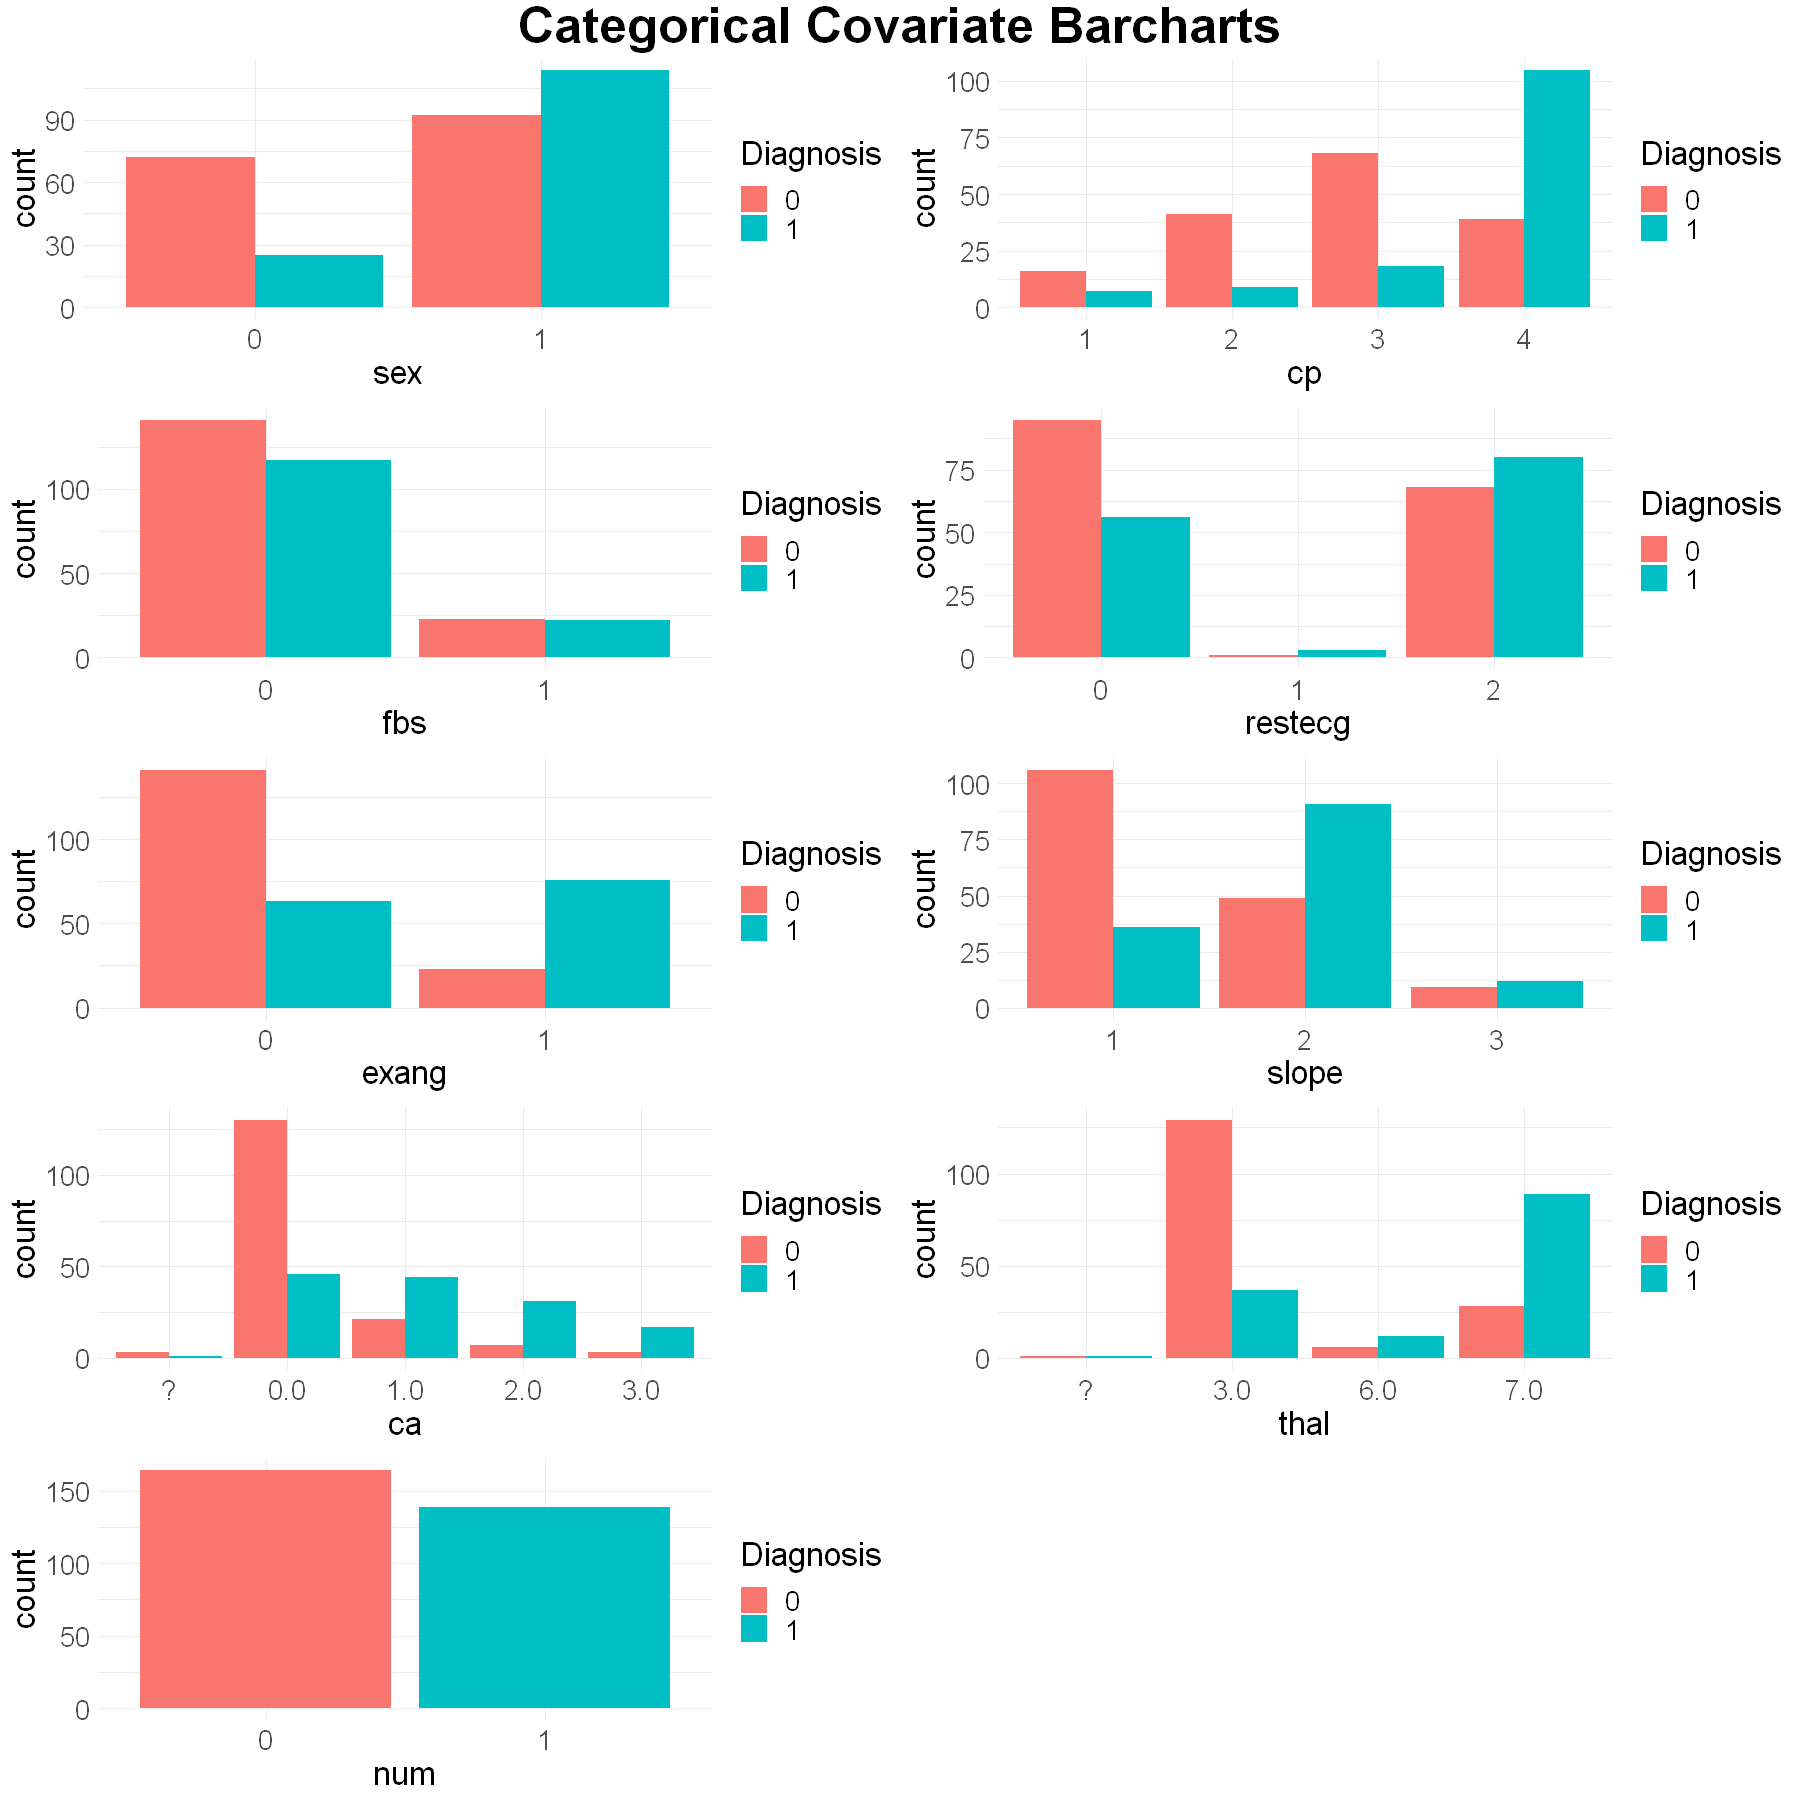

In [6]:
# Main developer: Christin Wang

draw_bar_chart <- function(data, categorical_vars, num) {
  ggplot(data, aes_string(x = categorical_vars, fill = num)) +
    geom_bar(position = "dodge") +
    theme_minimal() +
    theme(text = element_text(size = 20)) +
    labs(x = categorical_vars, fill = "Diagnosis")
}

sex_bar <- draw_bar_chart(heart_data, "sex", "num")
cp_bar <- draw_bar_chart(heart_data, "cp", "num")
fbs_bar <- draw_bar_chart(heart_data, "fbs", "num")
restecg_bar <- draw_bar_chart(heart_data, "restecg", "num")
exang_bar <- draw_bar_chart(heart_data, "exang", "num")
slope_bar <- draw_bar_chart(heart_data, "slope", "num")
ca_bar <- draw_bar_chart(heart_data, "ca", "num")
thal_bar <- draw_bar_chart(heart_data, "thal", "num")
num_bar <- draw_bar_chart(heart_data, "num", "num")

grid.arrange(
  sex_bar, cp_bar, fbs_bar, restecg_bar,
  exang_bar, slope_bar, ca_bar, thal_bar, num_bar,
  ncol = 2,
  top = textGrob("Categorical Covariate Barcharts", gp = gpar(fontsize = 30, fontface = "bold"))
)

**[Graph2] Correlation Matrix Heatmap of Numerical Variables**

- Within this heatmap, `trestbps`&`age`, `age`&`thalach`, `oldpeak`&`thalach` are shown to have the strongest correlation. So, we might want to put multicollinearity into concern for these variables, probably dropping one afterwards.
    

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(categorical_vars)

  # Now:
  data %>% select(all_of(categorical_vars))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


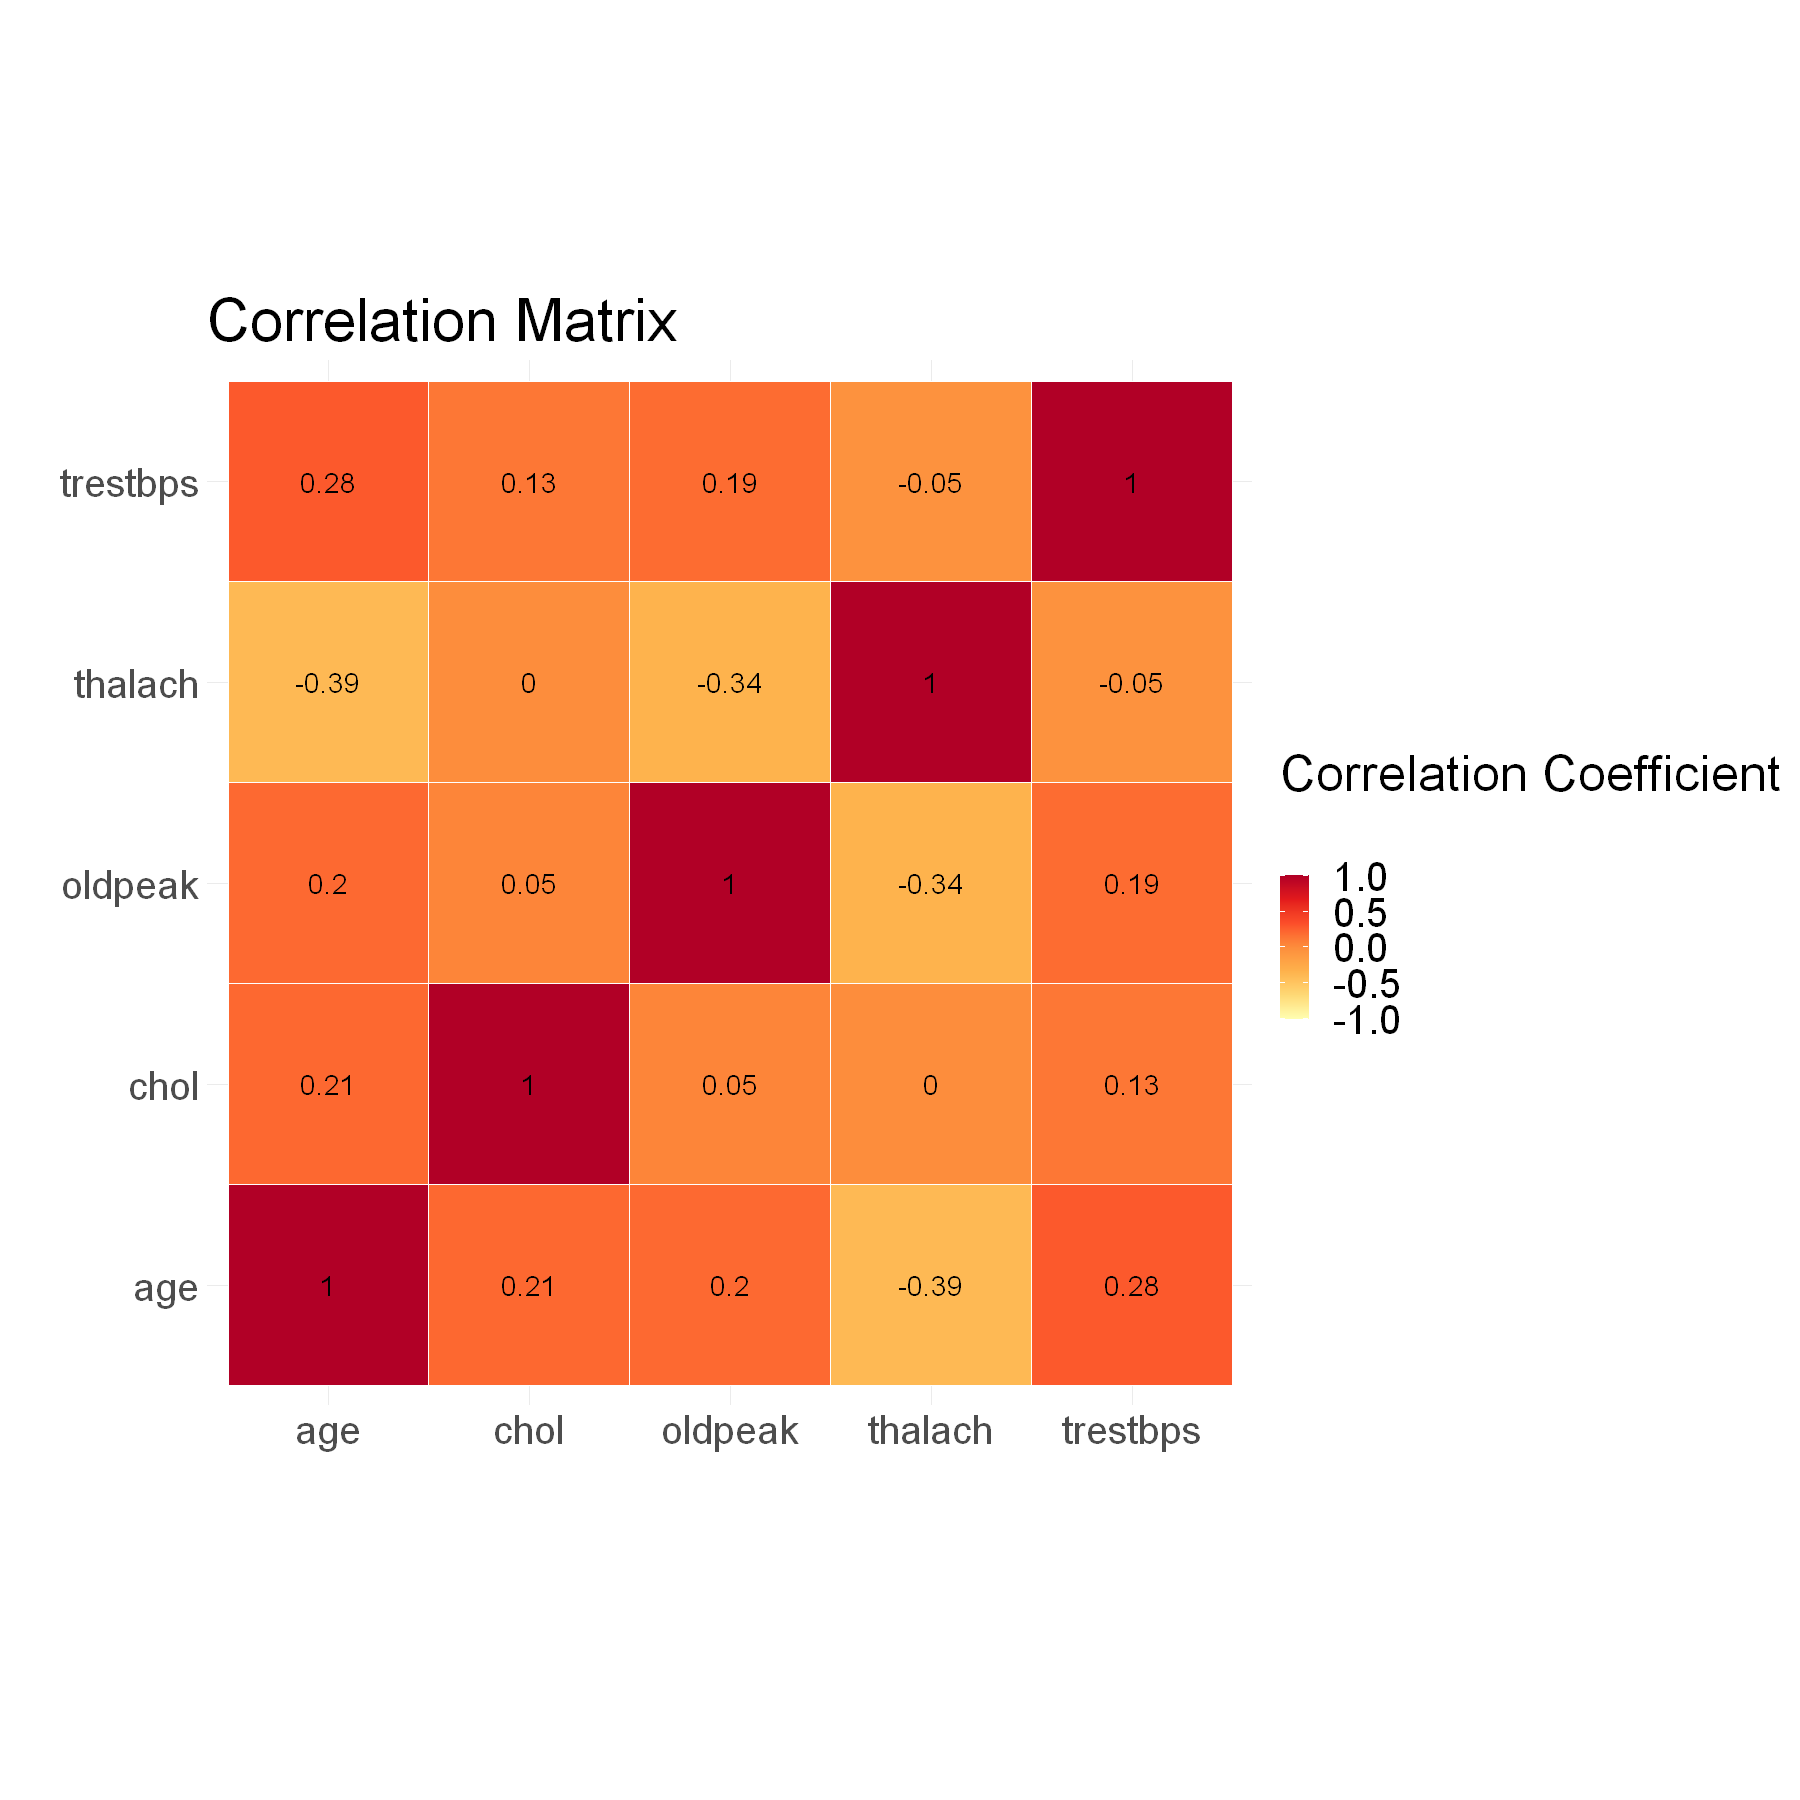

In [7]:
# Main developer: Christin Wang

corr_matrix <- heart_data %>%
            select(-categorical_vars, -num) %>%
            cor() %>%
            as_tibble(rownames = 'var1') %>%
            pivot_longer(-var1, names_to = "var2", values_to = "corr")

plot_corr_matrix <- corr_matrix %>%
   ggplot(aes(var1, var2)) +
   geom_tile(aes(fill = corr), color = "white") +
   scale_fill_distiller("Correlation Coefficient \n",
       palette =  "YlOrRd",
       direction = 1, 
       limits = c(-1, 1)
     ) +
     labs(x = "", y = "") +
     theme_minimal() +
     theme(text = element_text(size = 30)) +
     coord_fixed() +
   geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6) +
   ggtitle("Correlation Matrix")

plot_corr_matrix

**[Graph3] Boxplots Comparing Heart Disease Diagnosis between Numerical Variables**

- By illustrating the distribution of numerical variables grouped by heart disease diagnosis, we can easily see the differences in the distribution of values, including the presence of outliers, mean, median and variability. Comparing these can help us identify which variables are more influential in predicting heart disease.

    We will compare the median since the mean may be affected by outliers.
    In this case, we see that `age`, `oldpeak` and `thalach` has a relatively big differences between diagnosis results. Thus, would be more useful in the prediction model.


Warning message:
"The dot-dot notation (`..y..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(y)` instead."


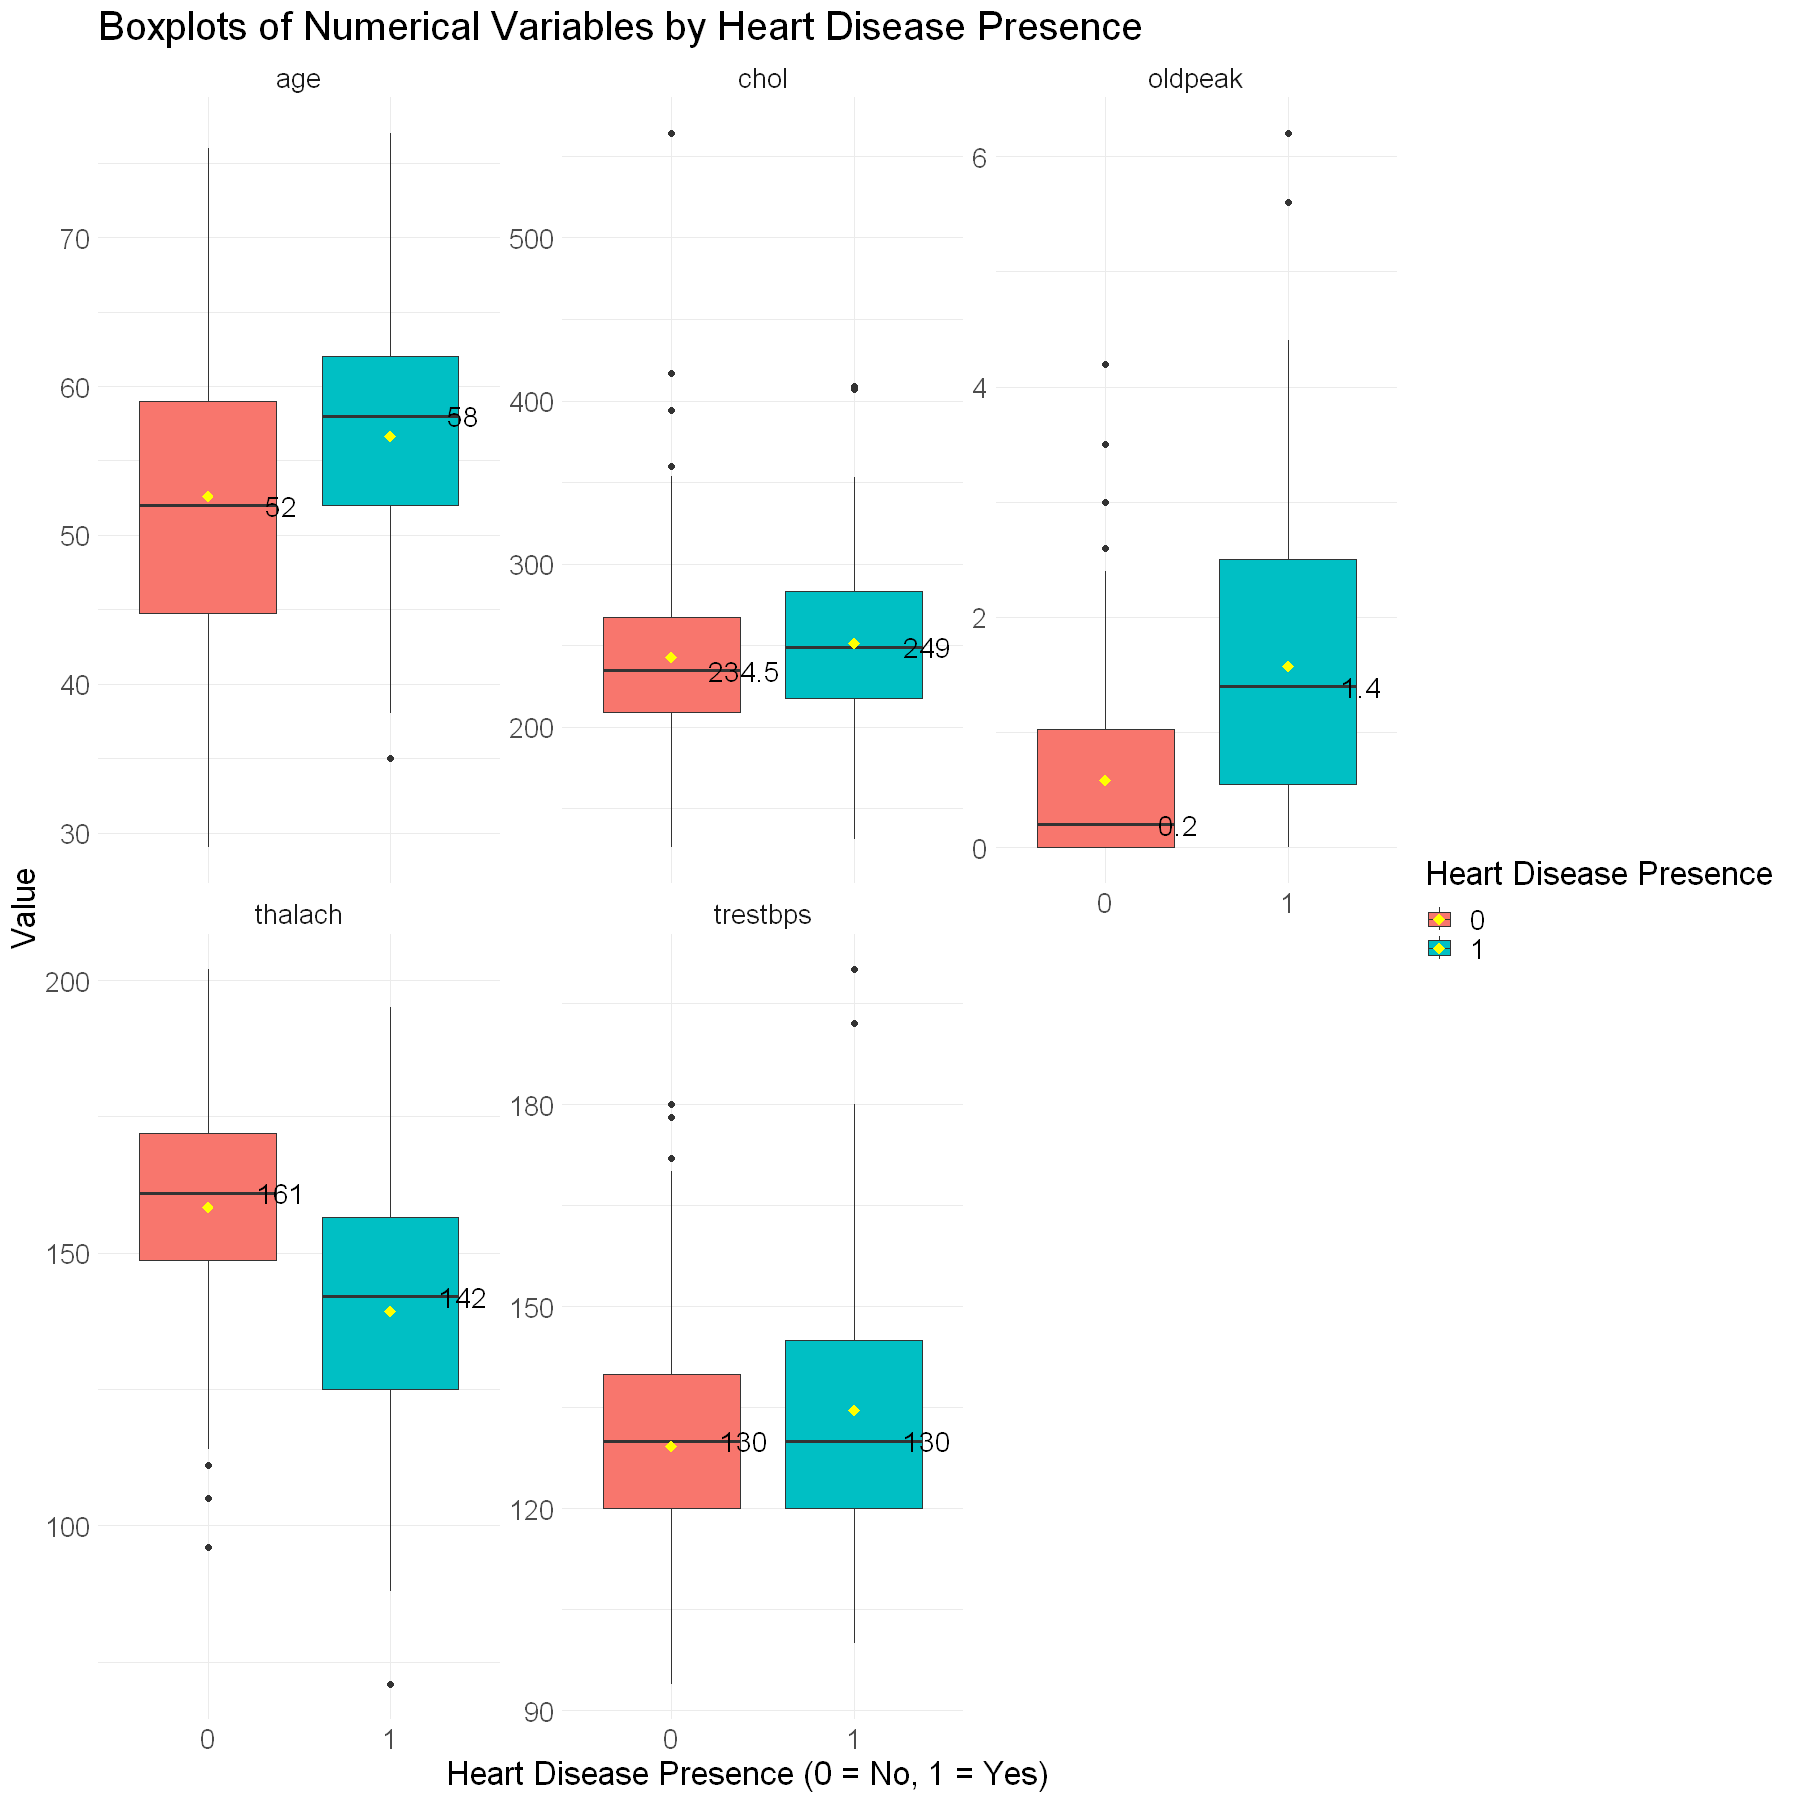

In [8]:
# Main developer: Christin Wang

heart_long <- heart_data %>%
  select(- categorical_vars) %>%
  pivot_longer(cols = -num , names_to = "variable", values_to = "value")

heart_boxplot <- heart_long %>%
  ggplot(aes(x = as.factor(num), y = value, fill = as.factor(num))) +
  geom_boxplot() +
  stat_summary(aes(label = round(..y.., 2)),
               fun = median,
               geom = "text",
               position = position_nudge(x = 0.4, y = 0),
               size = 6) +
  facet_wrap(~ variable, scales = "free_y") +
  stat_summary(aes(as.factor(num), value, fill = as.factor(num)),
               fun = mean,
               colour = "yellow",
               geom = "point",
               shape = 18,
               size = 3) +
  theme_minimal() +
  theme(text = element_text(size = 20)) +
  labs(title = "Boxplots of Numerical Variables by Heart Disease Presence", 
       x = "Heart Disease Presence (0 = No, 1 = Yes)", y = "Value") +
  scale_fill_discrete(name = "Heart Disease Presence")
heart_boxplot



#### Visualization Conclusion

After looking into the 4 graphs, we get a comprehensive overview of the data. At this point, I assume that `age`, `oldpeak`, `thalach`, `cp`, `restecg`, `exang`, `slope`, `ca` and `thal`, these 9 covariates are more relevant to heart disease diagnosis. Additionally, there may be multicollinearity amongst the variables `trestbps`,`age`, `thalach` and `oldpeak`.

### B. Methods

### 1. Split data into train & test

In [9]:
# Main developer: Christin Wang

heart_split <- 
    heart_data %>%
    initial_split(prop = 0.7, strata = num)
    
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

### 2. Fit the full Logistic Regression model by the training set

In [10]:
# Main developer: Christin Wang

heart_full_log <- glm(num ~ .,
                data = heart_train,
                family = binomial)

heart_full_tidy <- heart_full_log %>%
    tidy() %>%
    mutate(estimate = exp(estimate)) %>%
    mutate_if(is.numeric, round, 2)

heart_full_tidy

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,4.85,-1.27,0.21
age,0.99,0.04,-0.27,0.78
sex1,23.29,0.91,3.48,0.00
cp2,5.68,1.04,1.66,0.10
cp3,2.42,0.92,0.96,0.34
cp4,30.18,1.01,3.37,0.00
trestbps,1.04,0.02,2.52,0.01
chol,1.01,0.01,1.79,0.07
fbs1,1.02,0.77,0.03,0.98


### 3. Check for Collinarity by using `vif`

In [11]:
# Main developer: Christin Wang

vif_value <- vif(heart_full_log) 

vif_df <- data.frame(
  Variable = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"),
  GVIF_Adj = c(1.297, 1.357, 1.173, 1.261, 1.184, 1.099, 1.055, 1.220, 1.099, 1.360, 1.219, 1.145, 1.102)
  ) %>%
  arrange(desc(GVIF_Adj))
  
vif_df

Variable,GVIF_Adj
<chr>,<dbl>
oldpeak,1.360
sex,1.357
age,1.297
trestbps,1.261
thalach,1.220
slope,1.219
chol,1.184
cp,1.173
ca,1.145


#### VIF interpretation
No variable has a `GVIF_Adj` (adjusted GVIF) greater than 5, it generally suggests that multicollinearity is not a severe issue in our model.

### 4. Forward selection
Make a forward selection. Out of the 13 models, select the best one in terms of its goodness of fit (smallest AIC).

Then re-fit a logistic regression model with the selected variables

In [12]:
# Main developer: Christin Wang

null_model <- glm(num ~ 1, data = heart_data, family = binomial)

forward_sel <- stepAIC(null_model, direction = "forward", 
                         scope = list(lower = null_model, upper = heart_full_log))

summary(forward_sel)

Start:  AIC=419.98
num ~ 1

           Df Deviance    AIC
+ thal      3   330.60 338.60
+ cp        3   331.86 339.86
+ ca        4   341.72 351.72
+ oldpeak   1   357.20 361.20
+ exang     1   359.54 363.54
+ thalach   1   360.90 364.90
+ slope     2   370.76 376.76
+ sex       1   393.93 397.93
+ age       1   402.54 406.54
+ restecg   2   407.84 413.84
+ trestbps  1   411.03 415.03
+ chol      1   415.78 419.78
<none>          417.98 419.98
+ fbs       1   417.79 421.79

Step:  AIC=338.6
num ~ thal

           Df Deviance    AIC
+ ca        4   274.50 290.50
+ cp        3   279.14 293.14
+ thalach   1   297.00 307.00
+ oldpeak   1   300.05 310.05
+ exang     1   300.20 310.20
+ slope     2   307.31 319.31
+ age       1   320.14 330.14
+ restecg   2   318.53 330.53
+ sex       1   327.67 337.67
+ chol      1   327.79 337.79
+ trestbps  1   327.83 337.83
<none>          330.60 338.60
+ fbs       1   330.51 340.51

Step:  AIC=290.5
num ~ thal + ca

           Df Deviance    AIC
+ cp   


Call:
glm(formula = num ~ thal + ca + cp + oldpeak + slope + sex + 
    trestbps + exang, family = binomial, data = heart_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.78439    4.46368  -1.744  0.08117 .  
thal3.0     -2.24995    3.70784  -0.607  0.54398    
thal6.0     -2.47520    3.77569  -0.656  0.51211    
thal7.0     -0.83940    3.71096  -0.226  0.82105    
ca0.0        1.12685    1.63454   0.689  0.49057    
ca1.0        3.40654    1.69270   2.012  0.04417 *  
ca2.0        4.07792    1.81968   2.241  0.02503 *  
ca3.0        3.34023    1.84440   1.811  0.07014 .  
cp2          1.41765    0.79381   1.786  0.07412 .  
cp3          0.32082    0.68953   0.465  0.64173    
cp4          2.57209    0.69400   3.706  0.00021 ***
oldpeak      0.46158    0.22843   2.021  0.04332 *  
slope2       1.49041    0.46137   3.230  0.00124 ** 
slope3       0.64413    0.89013   0.724  0.46929    
sex1         1.47598    0.50889   2.900  0.00373 ** 
trestbps

In [31]:
# Main developer: Rongze Wang
# Contributor: Christin Wang (fixed a line)

forward_tidy <- forward_sel %>%
    tidy() %>%
    mutate(estimate=exp(estimate)) %>%
    mutate_if(is.numeric, round, 3)

forward_tidy

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.000,4.464,-1.744,0.081
thal3.0,0.105,3.708,-0.607,0.544
thal6.0,0.084,3.776,-0.656,0.512
thal7.0,0.432,3.711,-0.226,0.821
ca0.0,3.086,1.635,0.689,0.491
ca1.0,30.161,1.693,2.012,0.044
ca2.0,59.023,1.820,2.241,0.025
ca3.0,28.226,1.844,1.811,0.070
cp2,4.127,0.794,1.786,0.074


We observe that this model contains too many high p-values, which cannot be rejected using a significance level of 5%. Therefore, we aim to find a more refined model.

### 5. Find more reduced model
We apply two methods to identify a more reduced model:
#### 5.1. Remove insignificant terms 
We remove terms with p-values higher than 5%. (However, given the presence of many dummy variables, we cannot remove every insignificant term.)

In [43]:
# Main developer: Christin Wang
significant_vars <- forward_tidy %>%
    filter(p.value < 0.05) %>%
    pull(term) 
significant_vars

[1] "ca1.0"    "ca2.0"    "cp4"      "oldpeak"  "slope2"   "sex1"     "trestbps"

In [54]:
# Main developer: Christin Wang
more_red_log <- glm(
    formula = num ~ ca + cp + oldpeak + slope + sex + trestbps,
    data = heart_train,
    family = "binomial"
)

summary(more_red_log)


Call:
glm(formula = num ~ ca + cp + oldpeak + slope + sex + trestbps, 
    family = "binomial", data = heart_train)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.49347    2.94934  -3.897 9.74e-05 ***
ca0.0         0.50338    1.62393   0.310 0.756578    
ca1.0         3.21253    1.70833   1.881 0.060039 .  
ca2.0         3.61738    1.84846   1.957 0.050352 .  
ca3.0         3.15178    2.11579   1.490 0.136316    
cp2           0.80524    0.92390   0.872 0.383448    
cp3           0.33730    0.79924   0.422 0.673004    
cp4           3.04840    0.81491   3.741 0.000183 ***
oldpeak       0.49455    0.27446   1.802 0.071559 .  
slope2        2.00807    0.56651   3.545 0.000393 ***
slope3        0.10968    1.00797   0.109 0.913352    
sex1          2.33046    0.57546   4.050 5.13e-05 ***
trestbps      0.03847    0.01380   2.787 0.005314 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family ta

#### 5.2. Lasso Regularization

In [55]:
# Main developer: Christin Wang
matrix_X_train <- 
    model.matrix(object = num ~., 
                data = heart_train) [, -1]

matrix_Y_train <- heart_train$num

cv_lambda_lasso <- 
   cv.glmnet(
        x = matrix_X_train, 
        y = matrix_Y_train,
        alpha = 1,
        family = "binomial",
        type.measure = "auc",
        nfolds = 10)
        
LASSO <- 
   glmnet(
   x = matrix_X_train, 
   y = matrix_Y_train,
   alpha = 1,
   family = "binomial",
   lambda = cv_lambda_lasso$lambda.min
 )
 coef(LASSO)

23 x 1 sparse Matrix of class "dgCMatrix"
                     s0
(Intercept)  0.24340912
age          0.00295756
sex1         0.98091123
cp2          .         
cp3          .         
cp4          1.37804867
trestbps     0.01394899
chol         0.00205108
fbs1         .         
restecg1     .         
restecg2     0.09704328
thalach     -0.02430401
exang1       0.13285450
oldpeak      0.25895442
slope2       0.66938575
slope3       .         
ca0.0       -1.41593168
ca1.0        .         
ca2.0        0.29239255
ca3.0        .         
thal3.0     -0.85536014
thal6.0      .         
thal7.0      0.26525001

In [56]:
# Main developer: Christin Wang
selected_data <- heart_train %>%
select(age, sex, cp, trestbps, chol, restecg, thalach, exang, oldpeak, slope, ca, thal, num) 

matrix_X_selected <- model.matrix(num ~ ., data = selected_data)[, -1]
matrix_Y_selected <- selected_data$num

lasso_model <- glm(
  formula = num ~ ., 
  data = selected_data, 
  family = "binomial"
)

summary(lasso_model)


Call:
glm(formula = num ~ ., family = "binomial", data = selected_data)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.137e+00  4.838e+00  -1.268 0.204626    
age         -9.841e-03  3.562e-02  -0.276 0.782353    
sex1         3.151e+00  8.973e-01   3.512 0.000444 ***
cp2          1.740e+00  1.037e+00   1.678 0.093291 .  
cp3          8.911e-01  8.977e-01   0.993 0.320858    
cp4          3.409e+00  1.011e+00   3.373 0.000743 ***
trestbps     4.120e-02  1.613e-02   2.554 0.010636 *  
chol         9.949e-03  5.555e-03   1.791 0.073306 .  
restecg1     1.319e+01  1.618e+03   0.008 0.993495    
restecg2     5.528e-01  5.652e-01   0.978 0.328098    
thalach     -5.755e-02  1.967e-02  -2.925 0.003440 ** 
exang1       2.604e-01  6.299e-01   0.413 0.679265    
oldpeak      3.213e-01  3.338e-01   0.962 0.335883    
slope2       1.524e+00  7.095e-01   2.148 0.031734 *  
slope3      -6.432e-01  1.398e+00  -0.460 0.645486    
ca0.0        2.034e+00  2.049e+0

In [ ]:
# Main developer: Rongze Wang
forward_tidy <- forward_sel %>%
    tidy(conf.int=TRUE, conf.level=0.95, exponentiate=TRUE) 

forward_tidy

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.161814e-04,4.46368171,-1.7439392,0.0811696993,1.623311e-07,0.489644
thal3.0,1.054041e-01,3.70784292,-0.6068092,0.5439775177,5.183509e-04,19.155886
thal6.0,8.414615e-02,3.77568522,-0.6555631,0.5121052469,3.005049e-04,17.039366
thal7.0,4.319687e-01,3.71095538,-0.2261957,0.8210492366,2.052168e-03,77.203362
ca0.0,3.085918e+00,1.63454144,0.6893978,0.4905729852,1.207654e-01,106.452254
ca1.0,3.016065e+01,1.69269622,2.0124923,0.0441680711,1.098226e+00,1149.517722
ca2.0,5.902253e+01,1.81968082,2.2410080,0.0250255587,1.716890e+00,2798.286769
ca3.0,2.822564e+01,1.84439898,1.8110131,0.0701388256,7.845459e-01,1416.461438
cp2,4.127424e+00,0.79380751,1.7858907,0.0741169502,8.889541e-01,20.498895


(Rongze Wang)

From the reduced logistic model, we see that the number of major vessels (1-3) colored by flourosopy `ca` have a significant positive coefficient with our response variable. The vessel No.2 `ca2.0` has the largest coefficient among the major vessels that the odd of the number of major vessel No.2 colored by flourosopy is about 60 times higher for the heart disease patients than the patients without heart disease.
    
From another prospect, the odd of asymptomatic of chest pain type `cp4` is about 13 times higher for patients with heart disease than those without disease. Besides, other coefficients, such as the slope of the peak exercise ST segment `slope`, the resting blood pressure (in mm Hg on admission to the hospital) `tretbps`, exercise induced angina `exang1`, ST depression induced by exercise relative to rest `oldpeak`, and the sex of patients `sex1`, have a odd from 1 to 4 times higher for the patients with heart disease than those without heart disease.
    
Meanwhile, The types of defect `thal`show smaller coefficients with the response than the other variables that the odds of fixed defect, normal and reversable defect are 8%, 10%, 43% higher for the heart disease patients than those without heart disease, respectively.

Furthermore, `trestbps`, `cp4`, `slope2`, `sex1`, `oldpeak`, `ca2.0`, and `ca1.0` show enough evidence to reject the null hyphothesis at a 5% significant level. `sex1` and `cp4` have the strongest association with the response variable among the input variables as they have really small p-values 0.0037267731 and 0.000210387, respectively.

### 6. Model Evaluation

(Rongze Wang)

Now, we can test the performance of our new logistic regression model on test set by using Confusion matrix and ROC graphs

In [ ]:
heart_full_log_testing <- glm(num ~ .,
                data = heart_test,
                family = binomial)
heart_pred_class <- 
        round(predict(heart_full_log_testing,type="response"),0)
head(heart_pred_class, 10)

1  2  3  4  5  6  7  8  9 10 
 1  0  1  0  1  0  0  0  0  0

(Rongze Wang)

In [ ]:
heart_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(heart_pred_class),
    reference = as.factor(heart_test$num),
    positive = '1'
)
heart_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 46  5
         1  4 37
                                          
               Accuracy : 0.9022          
                 95% CI : (0.8224, 0.9543)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : 8.961e-14       
                                          
                  Kappa : 0.8025          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.8810          
            Specificity : 0.9200          
         Pos Pred Value : 0.9024          
         Neg Pred Value : 0.9020          
             Prevalence : 0.4565          
         Detection Rate : 0.4022          
   Detection Prevalence : 0.4457          
      Balanced Accuracy : 0.9005          
                                          
       'Positive' Class : 1               
                                    

(Rongze Wang)

In [ ]:
heart_new_pred_class <- 
        round(predict(forward_sel,type="response", newdata=heart_test),0)
head(heart_new_pred_class, 10)

1  2  3  4  5  6  7  8  9 10 
 1  0  1  0  1  0  0  0  0  0

(Rongze Wang)

In [ ]:
heart_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(heart_new_pred_class),
    reference = as.factor(heart_test$num),
    positive = '1'
)
heart_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 46  9
         1  4 33
                                          
               Accuracy : 0.8587          
                 95% CI : (0.7705, 0.9226)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : 1.237e-10       
                                          
                  Kappa : 0.7125          
                                          
 Mcnemar's Test P-Value : 0.2673          
                                          
            Sensitivity : 0.7857          
            Specificity : 0.9200          
         Pos Pred Value : 0.8919          
         Neg Pred Value : 0.8364          
             Prevalence : 0.4565          
         Detection Rate : 0.3587          
   Detection Prevalence : 0.4022          
      Balanced Accuracy : 0.8529          
                                          
       'Positive' Class : 1               
                                    

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



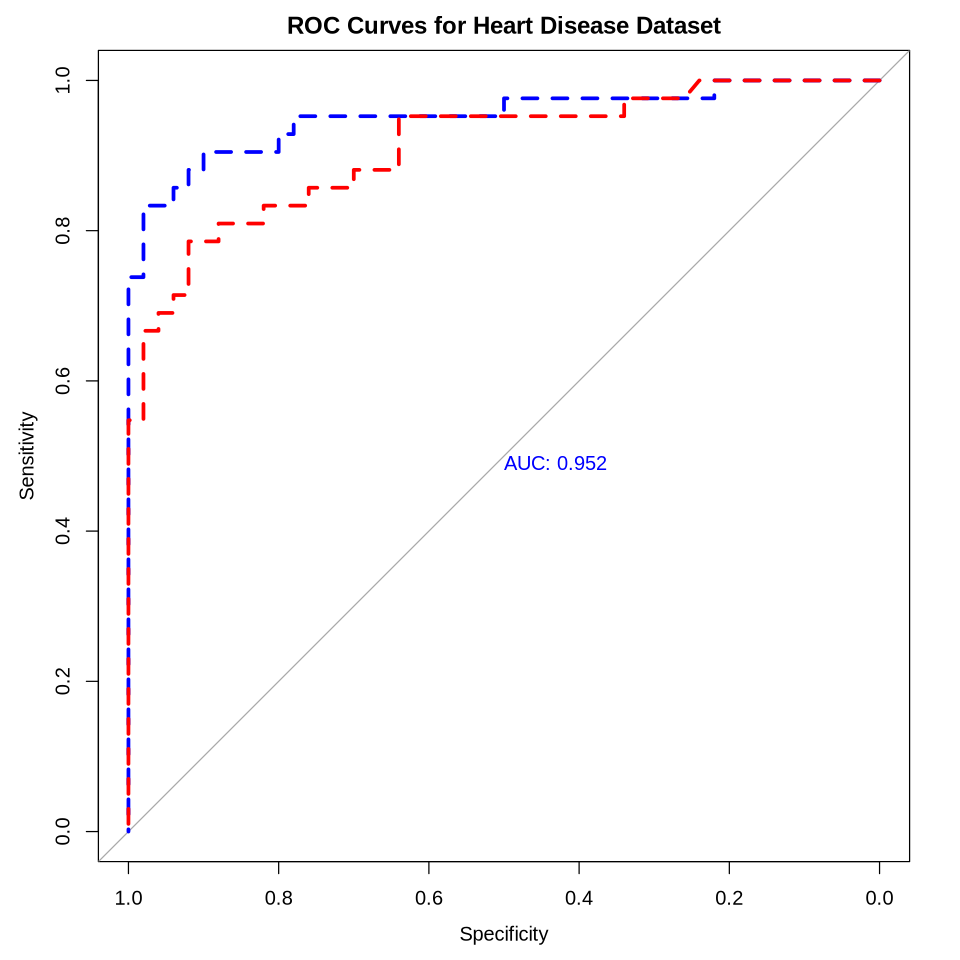

In [ ]:
# Main developer: Rongze Wang

options(repr.plot.width = 8, repr.plot.height = 8)

ROC_full_log_testing <- roc(
  response = heart_test$num,
  predictor = predict(heart_full_log_testing,type='response')
)

ROC_red_log <- roc(
  response = heart_test$num,
  predictor = predict(forward_sel,type='response',newdata=heart_test)
)

plot(ROC_full_log_testing,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Heart Disease Dataset"
)
lines.roc(ROC_red_log,print.auc = TRUE, col = "red", lwd = 3, lty = 2)


As we can see from the ROC curves of our reduced logistic model and full logistic model, the full model shows a larger value of AUC than the reduced model. This means that our reduced logistic model after the forward selection does not fit the data better.

### 7. Interpretation
Tidy the results of the chosen model, interpret coefficients, p-values, confidence intervals.

## III. Discussion

## IV. References (APA)

- Lloyd-Jones, D. M., Larson, M. G., Beiser, A., & Levy, D. (1999). Lifetime risk of developing coronary heart disease. The Lancet, 353(9147), 89-92. https://doi.org/10.1016/S0140-6736(98)10279-9

- Inouye, M., Abraham, G., Nelson, C. P., Wood, A. M., Sweeting, M. J., Dudbridge, F., Lai, F. Y., Kaptoge, S., Brozynska, M., Wang, T., Ye, S., Webb, T. R., Rutter, M. K., Tzoulaki, I., Patel, R. S., Loos, R. J. F., Keavney, B., Hemingway, H., Thompson, J., etc. UK Biobank CardioMetabolic Consortium CHD Working Group. (2018). Genomic risk prediction of coronary artery disease in 480,000 adults: Implications for primary prevention. Journal of the American College of Cardiology, 72(16), 1883-1893. https://doi.org/10.1016/j.jacc.2018.07.079

- Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

